# BE Anomaly Detection
#### Michta Emmanuel - Louvet Matthieu - Blanc Axel

Les données sont brutes, et contiennent a priori des anomalies. Nous utiliserons des techniques de Outlier Detection et non de Novelty Detection, vu que nous n'avons pas de dataset propre (cad sans anomalie).

Nous n'avons pas de description du système physique, ni de description précise d'une anomalie (par exemple, un seuil d'admissibilité des valeurs pour les capteurs). Par conséquent, notre travail a reposé sur la définition d'une anomalie, à partir des données, et s'approche par conséquent plus ou moins de la réalité physique d'une anomalie. 
                                                                                            

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
def plotAnomalyScore2D_bis(df, clf_name, clf, f1,f2):
    """
        Same as plotAnomalyScore2D, but with a classifier trained on the whole dataset
        - df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        - clf_name: String value - name of the outlier detection model
        - clf: Scikit Learn model instance - the trained outlier detection model
    """
    if clf_name == 'LOF':
        score = clf.negative_outlier_factor_
    else:
        score = clf.decision_function(df)
    
    plt.figure()
    sc = plt.scatter(x=df[f1],y=df[f2], c=-score, cmap='Reds')
    plt.colorbar(sc, label='anomaly score')
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(clf_name)

In [3]:
# Agrandissement des plot figures #
plt.rcParams['figure.figsize'] = [10, 5]

## Part 1 : Data observation and cleaning

In [4]:
df = pd.read_csv("dataset.csv")
df.describe()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
count,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000,162702.000000
mean,0.000009,0.000011,0.000031,0.000005,0.000016,-0.000005,-0.000002,0.000003,-0.000021,0.000026,0.000030
std,0.999950,0.999925,0.999961,0.999925,0.999963,0.999926,0.999950,0.999949,0.997770,0.999686,0.999847
min,-3.211980,-3.395387,-3.325651,-3.378450,-3.281286,-4.200181,-3.898025,-3.524957,-13.704556,-12.044778,-3.183571
25%,-0.678808,-0.482716,-0.629123,-0.491585,-0.612334,-0.559023,-0.606135,-0.736398,-0.593096,-0.498480,-0.658530
50%,0.041883,0.180360,0.041442,0.147397,0.117040,0.153972,0.186038,-0.012354,-0.034882,-0.257635,-0.015437
75%,0.743973,0.656920,0.659246,0.636887,0.712393,0.685353,0.718237,0.802395,0.508232,0.359773,0.636740
max,5.013899,6.260782,8.652950,8.359670,6.424227,5.638259,3.735957,4.667058,8.203706,5.597387,9.204384


Les distrubitions des données sont centrées réduites.

In [5]:
df = df.drop(['day_cycle_window'], axis=1)


 Certains points sont éloignés d'une distribution normale des données: 



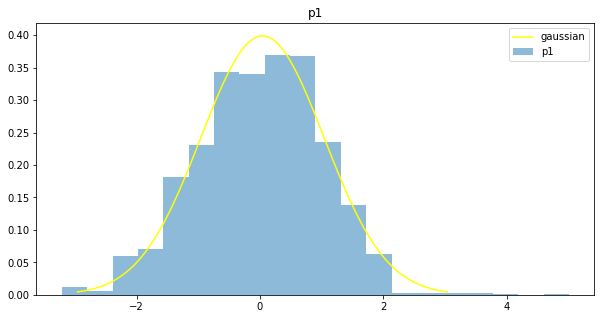

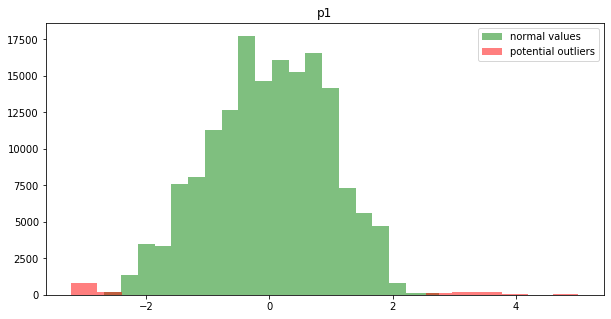

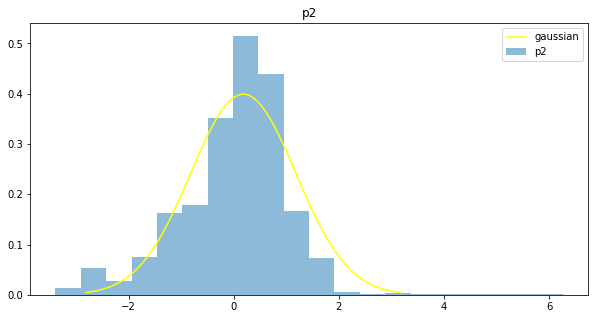

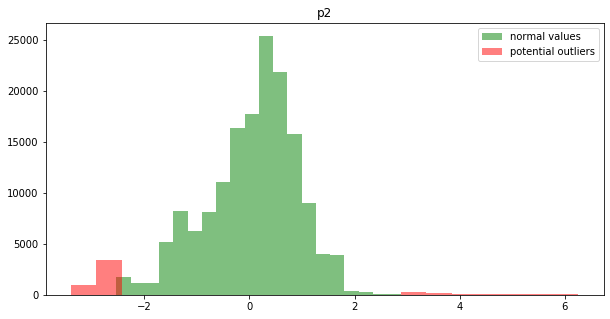

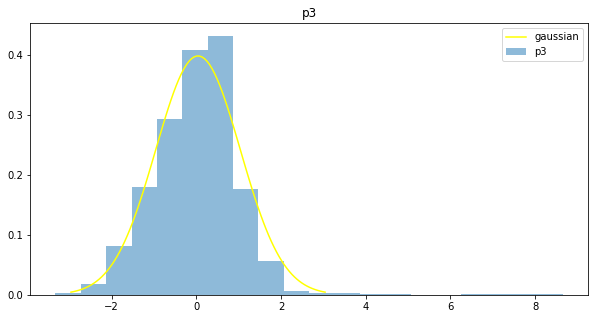

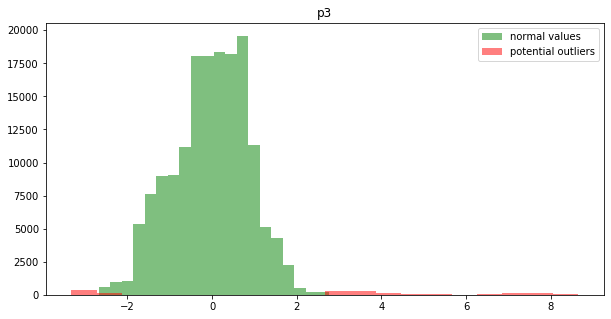

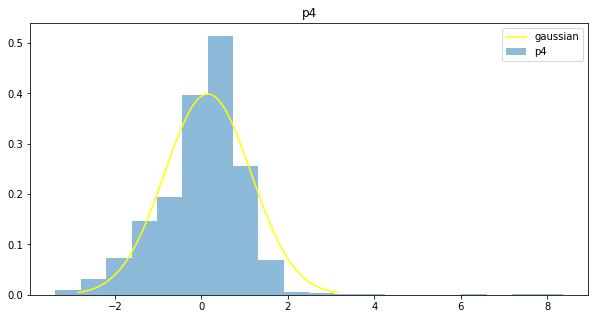

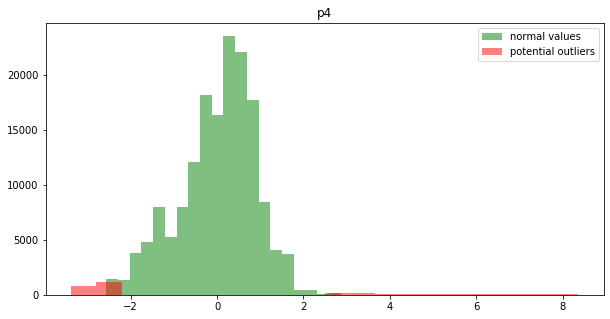

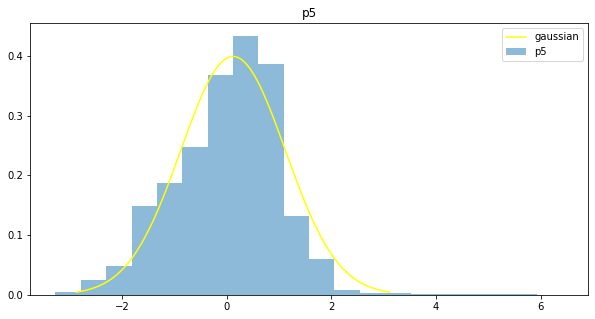

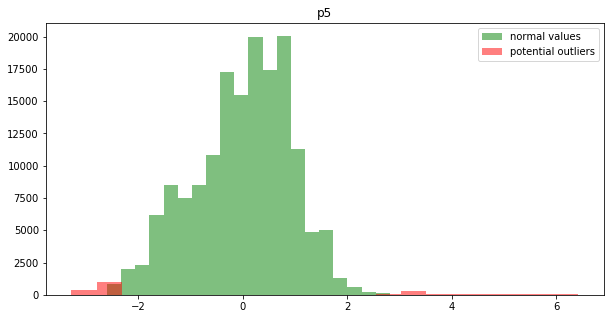

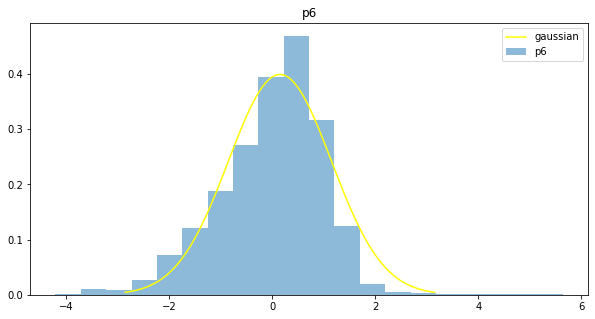

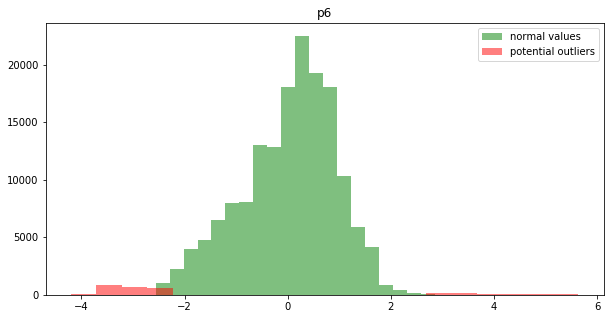

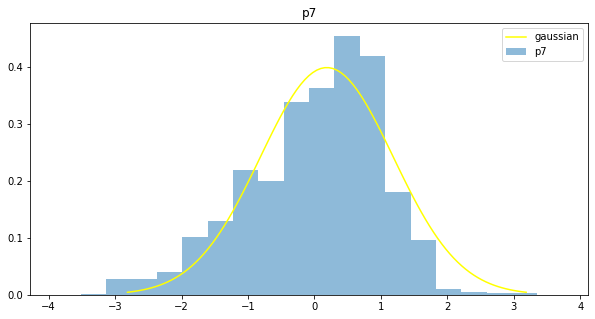

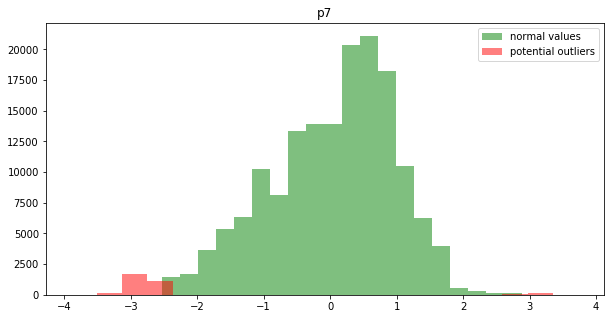

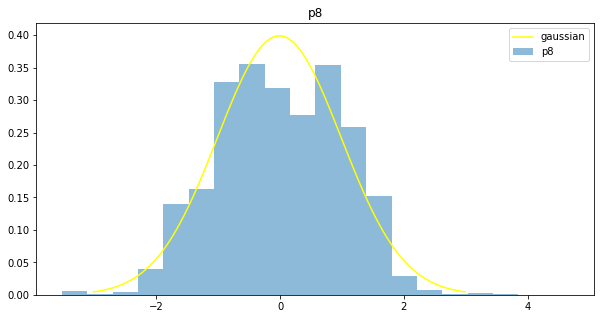

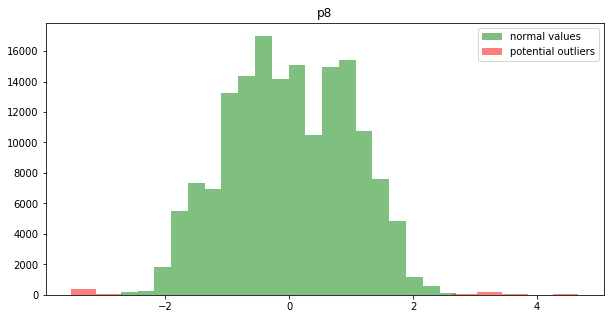

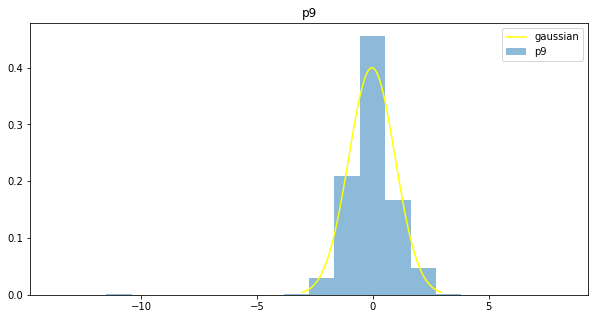

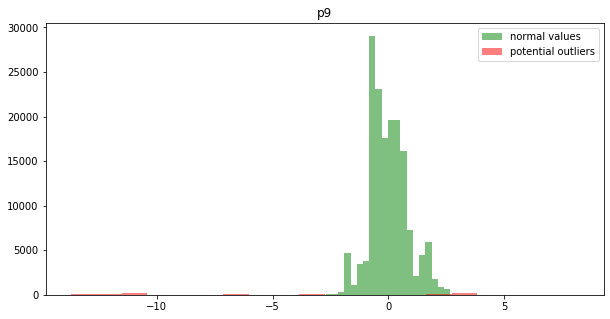

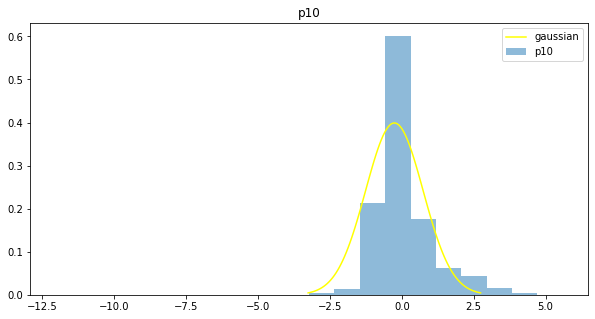

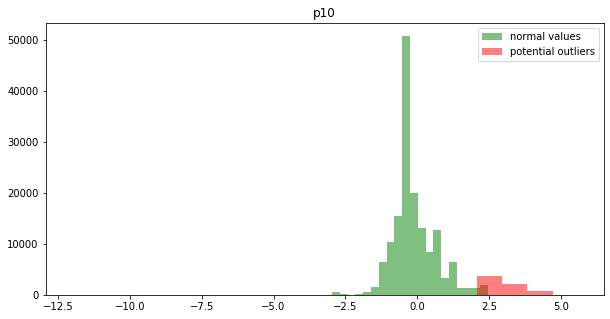

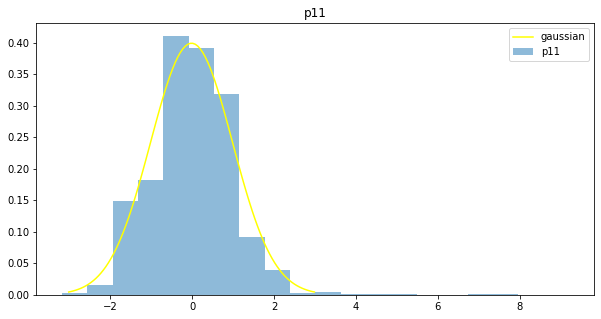

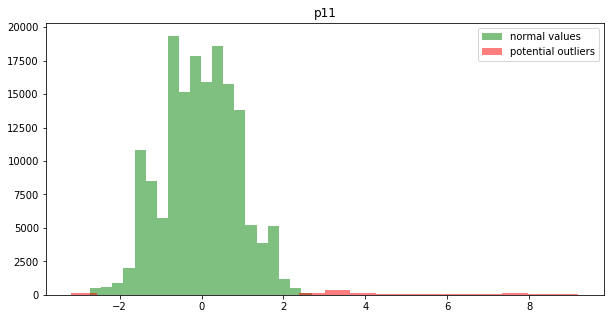

In [6]:
count_outliers = 0
print('\n Certains points sont éloignés d\'une distribution normale des données: \n')
for col in df.columns.unique():
    m = df[col].median()
    s = df[col].std()
    x = np.linspace(m - 3*s, m + 3*s, 100)
    gaussian = stats.norm.pdf(x, m, s)

    ins = df[stats.norm.pdf(df[col], m, s)>0.01];
    outs = df[stats.norm.pdf(df[col], m, s)<0.01];
    
    count_outliers = count_outliers + outs.shape[0]

    plt.figure()
    l = plt.hist(df[col], density=True, bins = 20, alpha=0.5, label = col)
    plt.plot(x, gaussian, color = 'yellow', label = 'gaussian')
    plt.legend()
    plt.title(col)
    plt.show()

    plt.figure()
    plt.hist(df[col],density=True, alpha=0.5)
    plt.hist(ins[col],  alpha=0.5,color='green',bins=20,label='normal values')
    plt.hist(outs[col], alpha=0.5, color='red', bins=20, label='potential outliers')
    plt.legend()
    plt.title(col)
    plt.show()

In [7]:
print("En approximant la distribution des données normalement, {:.2f} % des données du dataset ont des valeurs ayant"
      .format(100 * count_outliers / (df.shape[0]*df.shape[1]))
      + " une probabilité d'apparition de 1%.")
print("En première approximation, il y aurait un taux de contamination de 0.61 %")

En approximant la distribution des données normalement, 1.61 % des données du dataset ont des valeurs ayant une probabilité d'apparition de 1%.
En première approximation, il y aurait un taux de contamination de 0.61 %


#### Regroupement par windows en prenant la moyenne et l'écart-type

In [8]:
df = pd.read_csv("dataset.csv")
df_windows_mean = df.groupby('day_cycle_window').mean()
df_windows_std = df.groupby('day_cycle_window').std()

for column in df_windows_mean.columns:
    df_windows_mean = df_windows_mean.rename(columns = {column : column + '_mean'})
    df_windows_std = df_windows_std.rename(columns = {column : column + '_std'})   

#### PCA à 2 composantes pour visualisation 2D

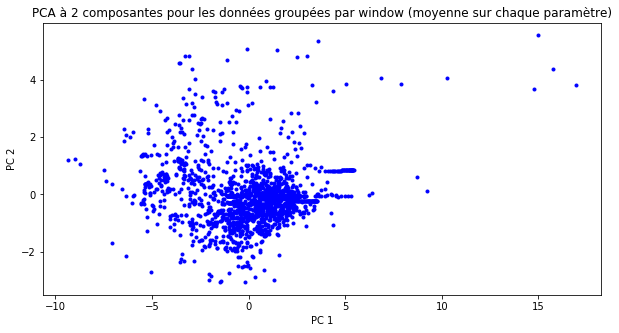

Variance expliquée pour 2 composantes = 75.63 %


In [9]:
pca = PCA(n_components=2)
pca.fit(df_windows_mean)
pca_windows_mean = pca.transform(df_windows_mean)
pca_windows_mean = pd.DataFrame(pca_windows_mean, columns = ['PC 1', 'PC 2'])
plt.plot(pca_windows_mean['PC 1'], pca_windows_mean['PC 2'], "b.")
plt.title("PCA à 2 composantes pour les données groupées par window (moyenne sur chaque paramètre)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()
print("Variance expliquée pour 2 composantes = {:.2f} %".format(sum(pca.explained_variance_ratio_)*100))

#### Clustering des windows

Des paramètres liés au vol, au jour, etc peuvent influer sur les capteurs de l'avion. On se propose de regrouper les windows par groupes pour les rassembler en windows semblables et faire ensuite une analyse des anomalies présentes par groupe.
Nous commencerons par une classification ascendante hiérarchique pour déterminer le nombre de groupes, puis par un Kmeans pour mieux isoler les groupes.

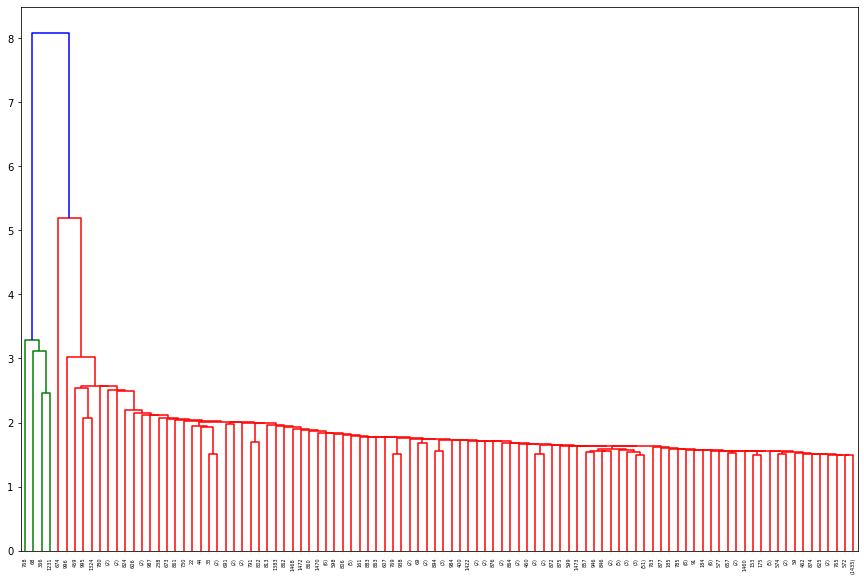

In [10]:
hierarchy_clusters = linkage(df_windows_mean)
plt.figure(figsize=(15, 10))
dendrogram(hierarchy_clusters, p=100, truncate_mode='lastp')
plt.show()

In [11]:
# On décide de faire 3 classes au vu du dendrogramme #

kmeans = KMeans(n_clusters=3).fit(df_windows_mean)

df_windows_mean_c1 = df_windows_mean[kmeans.labels_ == 0]
df_windows_mean_c2 = df_windows_mean[kmeans.labels_ == 1]
df_windows_mean_c3 = df_windows_mean[kmeans.labels_ == 2]

df_windows_std_c1 = df_windows_std[kmeans.labels_ == 0]
df_windows_std_c2 = df_windows_std[kmeans.labels_ == 1]
df_windows_std_c3 = df_windows_std[kmeans.labels_ == 2]

In [12]:
df_windows_mean_c1.head()

,p1_mean,p2_mean,p3_mean,p4_mean,p5_mean,p6_mean,p7_mean,p8_mean,p9_mean,p10_mean,p11_mean
day_cycle_window,,,,,,,,,,,
1_1_12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.42981,-0.085217,0.303699
1_1_13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.42981,-0.089727,0.186059
1_1_14,0.131038,0.143622,0.157089,0.186167,0.201920,0.067617,0.157327,0.043900,-0.42981,-0.089215,0.183239
1_1_15,0.128040,0.139088,0.156235,0.184080,0.198019,0.063925,0.154734,0.039251,-0.42981,-0.088757,0.189385
1_1_16,0.141339,0.159847,0.176081,0.198215,0.202146,0.080420,0.168087,0.059303,-0.42981,-0.089225,0.221397


In [13]:
day_cycle_window = df['day_cycle_window']
df_windows_c1 = pd.concat([df_windows_mean_c1, df_windows_std_c1], axis=1, sort=False)
df_windows_c2 = pd.concat([df_windows_mean_c2, df_windows_std_c2], axis=1, sort=False)
df_windows_c3 = pd.concat([df_windows_mean_c3, df_windows_std_c3], axis=1, sort=False)

In [14]:
df_windows_c1.head()

,p1_mean,p2_mean,p3_mean,p4_mean,p5_mean,p6_mean,p7_mean,p8_mean,p9_mean,p10_mean,...,p2_std,p3_std,p4_std,p5_std,p6_std,p7_std,p8_std,p9_std,p10_std,p11_std
day_cycle_window,,,,,,,,,,,,,,,,,,,,,
1_1_12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.42981,-0.085217,...,0.077160,0.074458,0.079167,0.084962,0.095682,0.085289,0.105400,0.0,0.008146,0.068842
1_1_13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.42981,-0.089727,...,0.004849,0.003302,0.007130,0.014593,0.007426,0.008084,0.010889,0.0,0.008337,0.005184
1_1_14,0.131038,0.143622,0.157089,0.186167,0.201920,0.067617,0.157327,0.043900,-0.42981,-0.089215,...,0.004842,0.001708,0.003564,0.004356,0.004667,0.003886,0.005667,0.0,0.010433,0.004445
1_1_15,0.128040,0.139088,0.156235,0.184080,0.198019,0.063925,0.154734,0.039251,-0.42981,-0.088757,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.007080,0.003892
1_1_16,0.141339,0.159847,0.176081,0.198215,0.202146,0.080420,0.168087,0.059303,-0.42981,-0.089225,...,0.012045,0.011125,0.009435,0.004374,0.010344,0.009286,0.012383,0.0,0.007397,0.011975


## Part 2: Détection d'anomalies

Nous allons ici essayer de détecter les points qui sont des outliers. Les windows qui contiennent le plus grand nombre de tels points seront alors considérées comme outliers.

Nous utiliserons comme classifiers: 
- One Class SVM, qui nous permettra de regrouper les windows avec des limites complexes
- Isolation Forest, pour éviter le swamping et le masking
- LOF, qui nous permettra de trouver les anomalies proches de clusters denses (locality aspect)

In [15]:
def score_scaler(lof_score, isf_score, svm_score) :
    
    # Anomaly score mis sur une échelle de 0 à 100 #
    
    lof_score = (lof_score-min(lof_score)) * 100 / (max(lof_score) - min(lof_score))
    isf_score = (isf_score-min(isf_score)) * 100 / (max(isf_score) - min(isf_score))
    svm_score = (svm_score-min(svm_score)) * 100 / (max(svm_score) - min(svm_score))

    # Total score / 100 : prise en compte des trois scores précédents #

    total_score = np.zeros(len(lof_score))
    for i in range(len(lof_score)) :
        total_score[i] = (lof_score[i] + isf_score[i] + svm_score[i])/3
    
    return total_score

In [16]:
threshold = 60 # Seuil au-dessus duquel une window est considérée comme anormale

### Cluster 1

In [17]:
clf_name = 'Isolation Forest'
isf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.10)
isf.fit(df_windows_c1)

clf_name = 'LOF'
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.10, novelty = False)
lof.fit(df_windows_c1)

clf_name = 'One Class SVM'
svm = OneClassSVM(nu=0.10, kernel="rbf", gamma=0.3)
svm.fit(df_windows_c1)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.3, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [18]:
lof_score_c1 = - lof.negative_outlier_factor_
isf_score_c1 = - isf.decision_function(df_windows_c1)
svm_score_c1 = - svm.decision_function(df_windows_c1)

total_score_1 = score_scaler(lof_score_c1, isf_score_c1, svm_score_c1)

outliers_index_1 = np.where(total_score_1 > threshold)
list_anomaly_c1 = df_windows_c1.index.values[outliers_index_1]

print("Liste des windows avec anomalie : {} ".format(list_anomaly_c1))
print("Nombre de windows anormales = {}".format(len(outliers_index_1[0])))
print("Contamination = {:.2f} %".format(len(outliers_index_1[0]) * 100 / df_windows_c1.shape[0]))

Liste des windows avec anomalie : ['3_2_44' '4_1_49' '4_2_15'] 
Nombre de windows anormales = 3
Contamination = 0.40 %


### Cluster 2

In [19]:
clf_name = 'Isolation Forest'
isf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.10)
isf.fit(df_windows_c2)

clf_name = 'LOF'
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.10, novelty = False)
lof.fit(df_windows_c2)

clf_name = 'One Class SVM'
svm = OneClassSVM(nu=0.10, kernel="rbf", gamma=0.3)
svm.fit(df_windows_c2)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.3, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [20]:
lof_score_c2 = - lof.negative_outlier_factor_
isf_score_c2 = - isf.decision_function(df_windows_c2)
svm_score_c2 = - svm.decision_function(df_windows_c2)

total_score_2 = score_scaler(lof_score_c2, isf_score_c2, svm_score_c2)

outliers_index_2 = np.where(total_score_2 > threshold)
list_anomaly_c2 = df_windows_c2.index.values[outliers_index_2]

print("Liste des windows avec anomalie : {} ".format(list_anomaly_c2))
print("Nombre de windows anormales = {}".format(len(outliers_index_2[0])))
print("Contamination = {:.2f} %".format(len(outliers_index_2[0]) * 100 / df_windows_c2.shape[0]))

Liste des windows avec anomalie : ['1_1_63' '1_1_68' '1_4_1' '1_4_2' '2_3_139' '2_3_144' '2_3_3' '3_3_129'
 '4_3_63'] 
Nombre de windows anormales = 9
Contamination = 2.85 %


### Cluster 3

In [21]:
clf_name = 'Isolation Forest'
isf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.10)
isf.fit(df_windows_c3)

clf_name = 'LOF'
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.10, novelty = False)
lof.fit(df_windows_c3)

clf_name = 'One Class SVM'
svm = OneClassSVM(nu=0.10, kernel="rbf", gamma=0.3)
svm.fit(df_windows_c3)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.3, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [22]:
lof_score_c3 = - lof.negative_outlier_factor_
isf_score_c3 = - isf.decision_function(df_windows_c3)
svm_score_c3 = - svm.decision_function(df_windows_c3)

total_score_3 = score_scaler(lof_score_c3, isf_score_c3, svm_score_c3)

outliers_index_3 = np.where(total_score_3 > threshold)
list_anomaly_c3 = df_windows_c3.index.values[outliers_index_3]

print("Liste des windows avec anomalie : {} ".format(list_anomaly_c3))
print("Nombre de windows anormales = {}".format(len(outliers_index_3[0])))
print("Contamination = {:.2f} %".format(len(outliers_index_3[0]) * 100 / df_windows_c3.shape[0]))

Liste des windows avec anomalie : ['1_1_62' '1_2_1' '2_1_1' '2_1_2' '3_1_1' '3_2_51' '3_2_52' '4_1_16'
 '4_1_17' '4_2_1' '4_2_2'] 
Nombre de windows anormales = 11
Contamination = 1.94 %


### Analyse sans cluster

In [23]:
df_windows = pd.concat([df_windows_mean, df_windows_std], axis=1, sort=False)

In [24]:
clf_name = 'Isolation Forest'
isf = IsolationForest(behaviour='new', n_estimators=100, contamination=0.10)
isf.fit(df_windows)

clf_name = 'LOF'
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.10, novelty = False)
lof.fit(df_windows)

clf_name = 'One Class SVM'
svm = OneClassSVM(nu=0.10, kernel="rbf", gamma=0.3)
svm.fit(df_windows)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.3, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [25]:
lof_score = - lof.negative_outlier_factor_
isf_score = - isf.decision_function(df_windows)
svm_score = - svm.decision_function(df_windows)

total_score = score_scaler(lof_score, isf_score, svm_score)

outliers_index = np.where(total_score > threshold)
list_anomaly = df_windows.index.values[outliers_index]

print("List of windows with anomaly : {} ".format(list_anomaly))
print("Nombre de windows anormales = {}".format(len(outliers_index[0])))
print("Contamination = {:.2f} %".format(len(outliers_index[0]) * 100 / df_windows.shape[0]))

List of windows with anomaly : ['1_1_68' '1_2_1' '1_4_1' '2_1_1' '3_1_1' '3_2_51' '3_2_52' '4_1_16'
 '4_1_17' '4_1_49' '4_2_1' '4_2_2'] 
Nombre de windows anormales = 12
Contamination = 0.73 %


## Part 3: Visualisation et conclusion

#### Clusters

In [26]:
list_anomaly_c = np.concatenate((list_anomaly_c1, list_anomaly_c2, list_anomaly_c3), axis=None)
print("Liste des windows avec anomalie pour tous les clusters : {} ".format(list_anomaly_c))
print("Nombre de windows anormales = {}".format(len(list_anomaly_c)))
print("Contamination = {:.2f} %".format(len(list_anomaly_c) * 100 / df_windows_mean.shape[0]))

Liste des windows avec anomalie pour tous les clusters : ['3_2_44' '4_1_49' '4_2_15' '1_1_63' '1_1_68' '1_4_1' '1_4_2' '2_3_139'
 '2_3_144' '2_3_3' '3_3_129' '4_3_63' '1_1_62' '1_2_1' '2_1_1' '2_1_2'
 '3_1_1' '3_2_51' '3_2_52' '4_1_16' '4_1_17' '4_2_1' '4_2_2'] 
Nombre de windows anormales = 23
Contamination = 1.41 %


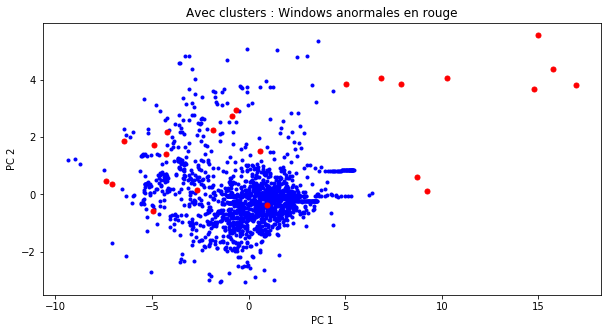

In [35]:
#### Visualisation des anomalies trouvées dans l'espace 2D de la PCA ####
plt.plot(pca_windows_mean['PC 1'], pca_windows_mean['PC 2'], "b.")
plt.plot(pca_windows_mean[np.isin(np.array(df_windows_mean.index), list_anomaly_c)]['PC 1'],
         pca_windows_mean[np.isin(np.array(df_windows_mean.index), list_anomaly_c)]['PC 2'], 
                                  "r.", markersize=10)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Avec clusters : Windows anormales en rouge")
plt.show()

#### Sans cluster

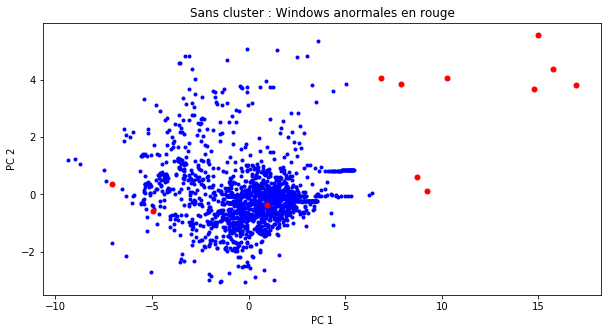

In [34]:
#### Visualisation des anomalies trouvées dans l'espace 2D de la PCA ####
plt.plot(pca_windows_mean['PC 1'], pca_windows_mean['PC 2'], "b.")
plt.plot(pca_windows_mean[np.isin(np.array(df_windows_mean.index), list_anomaly)]['PC 1'],
         pca_windows_mean[np.isin(np.array(df_windows_mean.index), list_anomaly)]['PC 2'], 
                                  "r.", markersize=10)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Sans cluster : Windows anormales en rouge")
plt.show()

In [29]:
print("Liste des windows avec anomalie : {} ".format(list_anomaly))
print("Nombre de windows anormales = {}".format(len(outliers_index[0])))
print("Contamination = {:.2f} %".format(len(outliers_index[0]) * 100 / df_windows.shape[0]))

Liste des windows avec anomalie : ['1_1_68' '1_2_1' '1_4_1' '2_1_1' '3_1_1' '3_2_51' '3_2_52' '4_1_16'
 '4_1_17' '4_1_49' '4_2_1' '4_2_2'] 
Nombre de windows anormales = 12
Contamination = 0.73 %


#### Conclusion

Certaines anomalies ont été détectées à la fois par l'analyse avec le clustering et l'analyse sans le clustering. 

In [30]:
anomaly_with_and_without_clustering = [anomaly for anomaly in list_anomaly if np.isin(anomaly, list_anomaly_c)]
print(anomaly_with_and_without_clustering)

['1_1_68', '1_2_1', '1_4_1', '2_1_1', '3_1_1', '3_2_51', '3_2_52', '4_1_16', '4_1_17', '4_1_49', '4_2_1', '4_2_2']


Celles-ci peuvent être considérées comme très anormales. Nous choisissons de garder les anomalies détecter par les deux méthodes.
Ainsi, notre étude conduit à conclure que les windows anormales sont les suivantes :

In [31]:
complete_list_anomalies = np.concatenate((list_anomaly_c, list_anomaly), axis=0)
complete_list_anomalies = np.unique(complete_list_anomalies)
print("Liste complète des windows avec anomalie : {} ".format(complete_list_anomalies))
print("Nombre de windows anormales = {}".format(len(complete_list_anomalies)))
print("Contamination = {:.2f} %".format(len(complete_list_anomalies) * 100 / df_windows_mean.shape[0]))

Liste complète des windows avec anomalie : ['1_1_62' '1_1_63' '1_1_68' '1_2_1' '1_4_1' '1_4_2' '2_1_1' '2_1_2'
 '2_3_139' '2_3_144' '2_3_3' '3_1_1' '3_2_44' '3_2_51' '3_2_52' '3_3_129'
 '4_1_16' '4_1_17' '4_1_49' '4_2_1' '4_2_15' '4_2_2' '4_3_63'] 
Nombre de windows anormales = 23
Contamination = 1.41 %


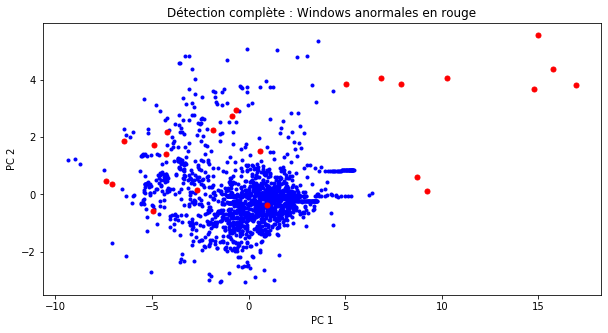

In [33]:
#### Visualisation des anomalies trouvées dans l'espace 2D de la PCA ####
plt.plot(pca_windows_mean['PC 1'], pca_windows_mean['PC 2'], "b.")
plt.plot(pca_windows_mean[np.isin(np.array(df_windows_mean.index), complete_list_anomalies)]['PC 1'],
         pca_windows_mean[np.isin(np.array(df_windows_mean.index), complete_list_anomalies)]['PC 2'], 
                                  "r.", markersize=10)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Détection complète : Windows anormales en rouge")
plt.show()